In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [61]:
class TreeNode():
  def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
    self.data = data
    self.feature_idx = feature_idx
    self.feature_val = feature_val
    self.prediction_probs = prediction_probs
    self.information_gain = information_gain
    self.feature_importance = self.data.shape[0] * self.information_gain
    self.left = None
    self.right = None

  def node_def(self) -> str:
    if self.left or self.right:
        return (
            f"🌿 NODE | Info Gain: {self.information_gain:.4f} | "
            f"Split: X[{self.feature_idx}] < {self.feature_val:.3f}"
        )
    else:
        unique_values, value_counts = np.unique(self.data[:, -1], return_counts=True)
        label_counts = ", ".join(
            f"{int(lbl)} → {cnt}" for lbl, cnt in zip(unique_values, value_counts)
        )
        probs = ", ".join(f"{p:.2f}" for p in self.prediction_probs)
        return f"🍁 LEAF | Labels: [{label_counts}] | Probs: [{probs}]"


In [114]:
class MyDecisionTree():
  def __init__(self, max_depth=4, min_samples_leaf=1, min_information_gain=0.0) -> None:
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.min_information_gain = min_information_gain

  def entropy(self, class_probabilities: list) -> float:
    probs = [p for p in class_probabilities if p > 0]
    if len(probs) == 0:
        return 0.0
    return sum(-p * np.log2(p) for p in probs)

  
  def class_probabilities(self,labels:list) -> list:
    total_count = len(labels)
    return [label_count/total_count for label_count in Counter(labels).values()]
  
  def data_entropy(self,labels:list)-> float: 
    return self.entropy(self.class_probabilities(labels))
  
  def partition_entropy(self,subsets: list) -> float: #weighted average
    total_count = sum([len(subset) for subset in subsets])
    return sum([self.data_entropy(subset)*(len(subset)/total_count) for subset in subsets])

  def split(self, data:np.array,feature_idx:int,feature_val: float)-> tuple:
    mask_below_threshold = data[:, feature_idx] < feature_val
    group1 = data[mask_below_threshold]
    group2 = data[~mask_below_threshold]
    return group1,group2
  
  def find_best_split(self, data:np.array)-> tuple:
    min_part_entropy = 1e9
    feature_idx_to_use = list(range(data.shape[1]-1))
    for idx in feature_idx_to_use:
      feature_vals = np.unique(data[:, idx])
      for feature_val in feature_vals:
        g1,g2 = self.split(data,idx,feature_val)
        part_entropy = self.partition_entropy([g1[:,-1],g2[:,-1]])
        if part_entropy <min_part_entropy:
          min_part_entropy = part_entropy
          min_entropy_feature_idx = idx
          min_entropy_feature_val = feature_val
          g1_min, g2_min = g1, g2
    return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy  
  def find_label_probs(self,data:np.array) -> np.array:
    labels_as_integers = data[:,-1].astype(int)
    total_labels = len(labels_as_integers)
    label_probabilities = np.zeros(len(self.labels_in_train),dtype=float)
    for i , label in enumerate(self.labels_in_train):
      label_index = np.where(labels_as_integers ==i)[0]
      if len(label_index)>0:
        label_probabilities[i] = len(label_index) / total_labels
    return label_probabilities
  
  def create_tree(self,data:np.array,current_depth:int)-> TreeNode:
    if current_depth>self.max_depth:
      return None
    split_1_data,split_2_data,split_feature_idx,split_feature_val,split_entropy = self.find_best_split(data)
    label_probabilities = self.find_label_probs(data)
    node_entropy = self.entropy(label_probabilities)

    information_gain = node_entropy-split_entropy
    node = TreeNode(data,split_feature_idx,split_feature_val,label_probabilities,information_gain)
    if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
        return node
    elif information_gain < self.min_information_gain:
        return node
    current_depth+=1
    node.left = self.create_tree(split_1_data,current_depth)
    node.right = self.create_tree(split_2_data,current_depth)
    return node
  
  def predict_one_sample(self,x: np.array) -> np.array:
    node = self.tree
    while node:
      pred_probs = node.prediction_probs
      if x[node.feature_idx] < node.feature_val:
          node = node.left
      else:
          node = node.right
    return pred_probs
  
  def train(self,X_train,Y_train):
    self.labels_in_train = np.unique(Y_train)
    train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)
    self.tree = self.create_tree(data=train_data, current_depth=0)
    self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
    self.calculate_feature_importance(self.tree)
    self.feature_importances = {k: v / total for total in (sum(self.feature_importances.values()),) for k, v in self.feature_importances.items()}

  def predict(self, X_set: np.array) -> np.array:
    pred_probs = self.predict_proba(X_set)
    preds = np.argmax(pred_probs, axis=1)
    
    return preds    

  def predict_proba(self, X_set: np.array) -> np.array:
    pred_probs = np.apply_along_axis(self.predict_one_sample, 1, X_set)
    return pred_probs
    
  def print_recursive(self, node: TreeNode, level=0, max_depth=3, prefix="ROOT"):
    if node is not None and level <= max_depth:
      indent = "│   " * level
      connector = "├── " if node.left or node.right else "└── "
      symbol = "🌿" if node.left or node.right else "🍁"
      print(f"{indent}{connector}{symbol} [{prefix}] {node.node_def()}")
      self.print_recursive(node.left, level + 1, max_depth, prefix="LEFT")
      self.print_recursive(node.right, level + 1, max_depth, prefix="RIGHT")


  def print_tree(self) -> None:
    self.print_recursive(node=self.tree)

  def calculate_feature_importance(self, node):
    if node != None:
      self.feature_importances[node.feature_idx] += node.feature_importance
      self.calculate_feature_importance(node.left)
      self.calculate_feature_importance(node.right)  

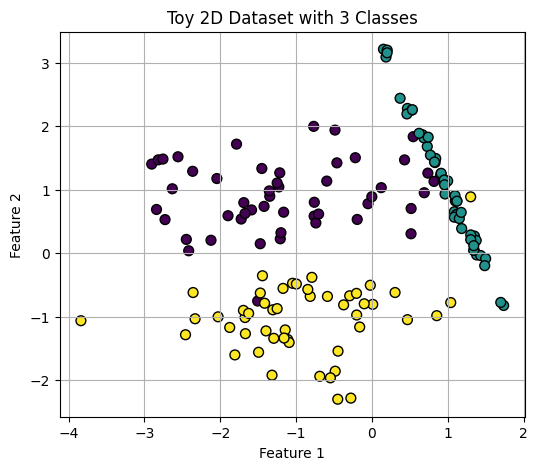

In [115]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np

# Generate 2D data with 3 classes
X, y = make_classification(
    n_samples=150,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=3,
    random_state=42
)

# Visualize it
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolor='k')
plt.title("Toy 2D Dataset with 3 Classes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


In [116]:
tree = MyDecisionTree(max_depth=4)
tree.train(X, y)
tree.print_tree()



├── 🌿 [ROOT] 🌿 NODE | Info Gain: 0.7560 | Split: X[1] < -0.195
│   ├── 🌿 [LEFT] 🌿 NODE | Info Gain: 0.2352 | Split: X[0] < 1.699
│   │   ├── 🌿 [LEFT] 🌿 NODE | Info Gain: 0.0421 | Split: X[0] < -1.495
│   │   │   ├── 🌿 [LEFT] 🌿 NODE | Info Gain: 0.4138 | Split: X[0] < -1.507
│   │   │   └── 🍁 [RIGHT] 🍁 LEAF | Labels: [2 → 38] | Probs: [0.00, 0.00, 1.00]
│   │   └── 🍁 [RIGHT] 🍁 LEAF | Labels: [1 → 2] | Probs: [0.00, 1.00, 0.00]
│   ├── 🌿 [RIGHT] 🌿 NODE | Info Gain: 0.6894 | Split: X[0] < 0.152
│   │   └── 🍁 [LEFT] 🍁 LEAF | Labels: [0 → 42] | Probs: [1.00, 0.00, 0.00]
│   │   ├── 🌿 [RIGHT] 🌿 NODE | Info Gain: 0.1986 | Split: X[0] < 0.826
│   │   │   ├── 🌿 [LEFT] 🌿 NODE | Info Gain: 0.6571 | Split: X[1] < 1.544
│   │   │   ├── 🌿 [RIGHT] 🌿 NODE | Info Gain: 0.0454 | Split: X[0] < 1.302


In [117]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

def plot_decision_boundary(model, X, y, resolution=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)

    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=50)


    plt.title(f"Decision Boundary (Train Accuracy: {acc:.2f})")
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    plt.show()


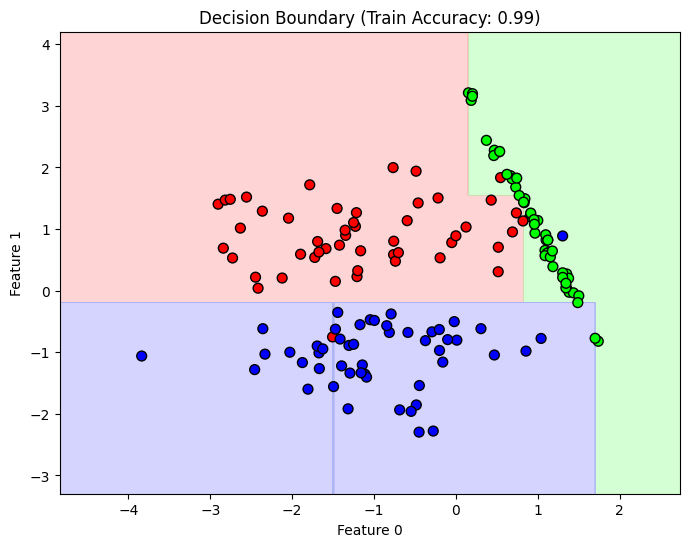

In [118]:
plot_decision_boundary(tree, X, y)

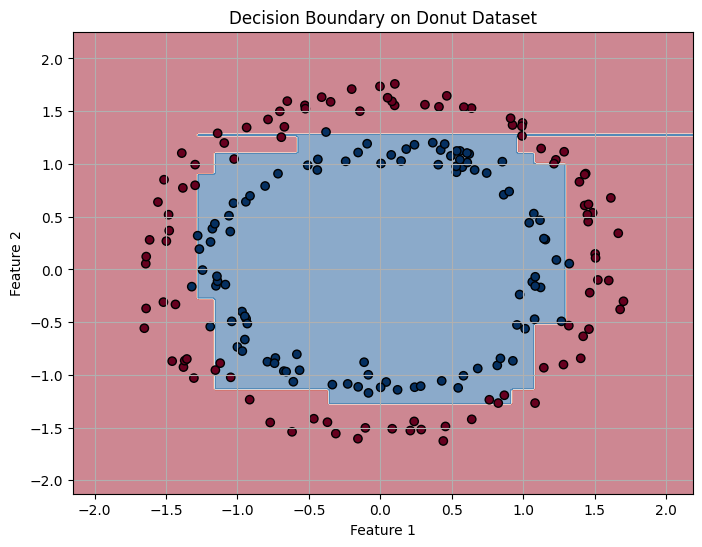

Accuracy on donut test set: 0.9350


In [120]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.7, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

tree = MyDecisionTree(max_depth=100)
tree.train(X_train, y_train)

def plot_decision_boundary(model, X, y):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k')
    plt.title("Decision Boundary on Donut Dataset")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

plot_decision_boundary(tree, X_test, y_test)

y_pred = tree.predict(X_test)
print(f"Accuracy on donut test set: {accuracy_score(y_test, y_pred):.4f}")


In [ ]:
from sklearn.tree import dec